      단계 1: 오프라인 모델 학습 (pkl 파일 생성)

--- [오프라인 학습] 1단계: 학습 데이터 생성 시작 ---
-> 819건의 성공 기록을 기반으로 데이터 재구성 중...
=> 학습 데이터 생성 완료! 총 1296630개 행 생성.

--- [오프라인 학습] 2단계: ML 랭킹 모델 학습 및 저장 시작 ---
-> 전체 819개 문제 중 655개는 학습용, 164개는 검증용으로 분리.

-> 모델 학습을 시작합니다 (검증용 데이터로 nDCG 점수를 모니터링합니다)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 1037332, number of used features: 3
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid_0's ndcg@5: 0.786703

--- 학습 완료 ---
✅ 최종 검증 nDCG@5 점수: 0.7867
=> 최고 성능의 모델을 'lgbm_ranker_model.pkl' 파일로 저장했습니다.

-> 학습 과정에 따른 nDCG 점수 변화를 시각화합니다.


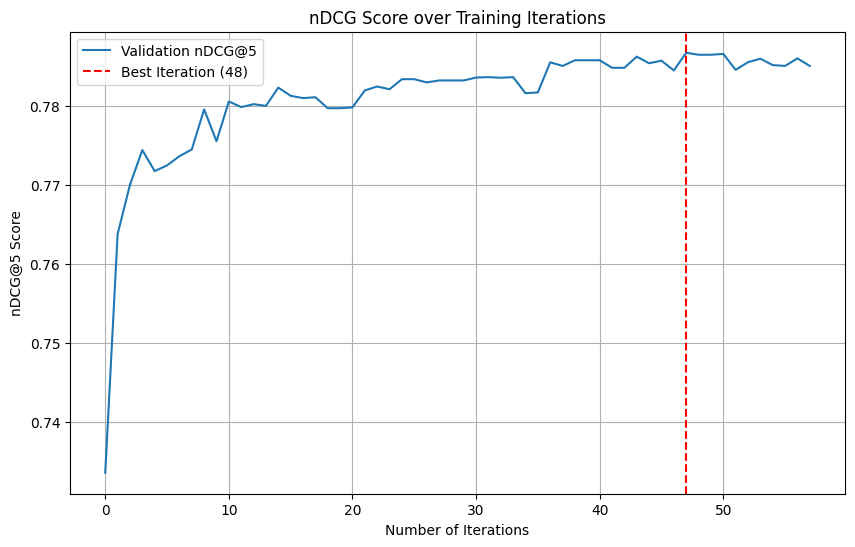


      단계 2: 온라인 예측 시스템 테스트

--- [온라인 예측] 초기화: RealtimeMatcher 로드 시작 ---
-> 드라이버 데이터베이스 로드 및 초기화 완료.

--- [온라인 예측] 요청 처리 시작: 서울 -> 부산 ---
-> 필터링 후 최종 1669명의 후보로 압축.
--- [온라인 예측] 요청 처리 완료 ---

---  최종 추천 기사 리스트 (상위 5명) ---
=> AI 모델이 예측한, 이 화물을 가장 잘 처리할 것 같은 기사 순위입니다.
     driver_id  predicted_score    distance  rating vehicle_type
4585     D4585         1.336433  140.898536    4.74          윙바디
480      D0480         1.260611    1.532349    4.78           탑차
20       D0020         1.203459    1.165262    4.46           카고
1525     D1525         1.160629  141.635421    4.97           카고
1880     D1880         1.064347    0.609152    4.99           냉동

      🎉 모든 과정이 완료되었습니다.


In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
from math import radians, sin, cos, sqrt, atan2
from datetime import datetime, timedelta
import os
from sklearn.model_selection import train_test_split

# ==============================================================================
# 1. 상수 및 헬퍼 함수 정의
# ==============================================================================

AVERAGE_TRUCK_SPEED_KPH = 50
CITY_COORDS = {
    '서울': (37.566, 126.978), '부산': (35.180, 129.075), '대구': (35.871, 128.601),
    '인천': (37.456, 126.705), '광주': (35.160, 126.851), '대전': (36.350, 127.384),
    '울산': (35.538, 129.311), '수원': (37.263, 127.028), '창원': (35.228, 128.681),
    '청주': (36.642, 127.489)
}


def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371
    dLat, dLon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dLat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dLon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


def estimate_time_from_distance(distance_km):
    return timedelta(hours=distance_km / AVERAGE_TRUCK_SPEED_KPH)


# ==============================================================================
# A. 오프라인 학습 부분
# ==============================================================================

def create_training_data(cargo_df, driver_df, results_df):
    print("\n--- [오프라인 학습] 1단계: 학습 데이터 생성 시작 ---")
    training_data_rows = []
    successful_matches = results_df[results_df['status'] == 'Matched'].copy()
    print(f"-> {len(successful_matches)}건의 성공 기록을 기반으로 데이터 재구성 중...")

    all_drivers = driver_df.copy()
    all_drivers['acceptance_rate'] = (all_drivers['accepted_requests'] / all_drivers['total_requests']).fillna(0)

    for index, log_row in successful_matches.iterrows():
        query_id = f"{index}_{log_row['request_id']}"
        actual_matched_driver = log_row['matched_driver']

        current_cargo_series = cargo_df[cargo_df['shipper_id'] == log_row['request_id']]
        if current_cargo_series.empty: continue
        current_cargo = current_cargo_series.iloc[0]

        # 기본 자격 필터링
        candidate_drivers = all_drivers[all_drivers['max_load_kg'] >= float(current_cargo['weight_kg'])].copy()
        cargo_type = current_cargo['cargo_type']
        if cargo_type == '냉장':
            candidate_drivers = candidate_drivers[candidate_drivers['vehicle_type'] == '냉장']
        elif cargo_type == '냉동':
            candidate_drivers = candidate_drivers[candidate_drivers['vehicle_type'] == '냉동']
        # ... (다른 화물 유형 필터링 로직 추가 가능)
        if candidate_drivers.empty: continue

        # 거리 기반 후보군 축소
        pickup_lat, pickup_lon = CITY_COORDS[current_cargo['origin']]
        lat_diff_limit, lon_diff_limit = 2.0, 2.0  # 200km 반경
        realistic_candidates = candidate_drivers[
            (abs(candidate_drivers['latitude'] - pickup_lat) < lat_diff_limit) &
            (abs(candidate_drivers['longitude'] - pickup_lon) < lon_diff_limit)
            ].copy()

        # 실제 매칭된 기사가 후보군에 포함되도록 보장
        if actual_matched_driver not in realistic_candidates['driver_id'].values:
            matched_driver_info = all_drivers[all_drivers['driver_id'] == actual_matched_driver]
            realistic_candidates = pd.concat([realistic_candidates, matched_driver_info], ignore_index=True)

        # 특징(Feature) 및 정답(Relevance) 생성
        realistic_candidates['distance'] = realistic_candidates.apply(
            lambda r: calculate_distance(r['latitude'], r['longitude'], pickup_lat, pickup_lon), axis=1
        )
        realistic_candidates['relevance'] = np.where(realistic_candidates['driver_id'] == actual_matched_driver, 2, 1)

        for _, driver_row in realistic_candidates.iterrows():
            training_data_rows.append({
                'query_id': query_id,
                'distance': driver_row['distance'],
                'rating': driver_row['rating'],
                'acceptance_rate': driver_row['acceptance_rate'],
                'relevance': driver_row['relevance']
            })

    final_df = pd.DataFrame(training_data_rows)
    print(f"=> 학습 데이터 생성 완료! 총 {len(final_df)}개 행 생성.")
    return final_df


def train_and_save_model(df_train, model_path='lgbm_ranker_model.pkl'):
    print("\n--- [오프라인 학습] 2단계: ML 랭킹 모델 학습 및 저장 시작 ---")
    
    # --- 데이터 분리 (학습용 / 검증용) ---
    all_query_ids = df_train['query_id'].unique()
    train_qids, val_qids = train_test_split(all_query_ids, test_size=0.2, random_state=42)

    train_df = df_train[df_train['query_id'].isin(train_qids)]
    val_df = df_train[df_train['query_id'].isin(val_qids)]
    
    print(f"-> 전체 {len(all_query_ids)}개 문제 중 {len(train_qids)}개는 학습용, {len(val_qids)}개는 검증용으로 분리.")

    # 학습용 및 검증용 데이터 준비
    features = ['distance', 'rating', 'acceptance_rate']
    X_train = train_df[features]
    y_train = train_df['relevance']
    group_train = train_df.groupby('query_id').size().to_list()

    X_val = val_df[features]
    y_val = val_df['relevance']
    group_val = val_df.groupby('query_id').size().to_list()

    # --- 모델 학습 및 평가 ---
    ranker = lgb.LGBMRanker(
        objective="lambdarank",
        metric="ndcg",
        random_state=42,
        n_estimators=200,
        learning_rate=0.05
    )
    
    print("\n-> 모델 학습을 시작합니다 (검증용 데이터로 nDCG 점수를 모니터링합니다)...")
    
    ranker.fit(
        X=X_train, 
        y=y_train, 
        group=group_train,
        eval_set=[(X_val, y_val)],
        eval_group=[group_val],
        eval_at=[5],
        callbacks=[lgb.early_stopping(10, verbose=True)]
    )

    # --- 최종 결과 출력 및 저장 ---
    best_score = ranker.best_score_['valid_0']['ndcg@5']
    print(f"\n--- 학습 완료 ---")
    print(f"✅ 최종 검증 nDCG@5 점수: {best_score:.4f}")
    
    joblib.dump(ranker, model_path)
    print(f"=> 최고 성능의 모델을 '{model_path}' 파일로 저장했습니다.")
    
    # ★★★ 주요 수정 사항: 시각화 코드를 함수 안으로 통합했습니다. ★★★
    print("\n-> 학습 과정에 따른 nDCG 점수 변화를 시각화합니다.")
    plt.figure(figsize=(10, 6))
    plt.plot(ranker.evals_result_['valid_0']['ndcg@5'], label='Validation nDCG@5')
    plt.axvline(x=ranker.best_iteration_ - 1, color='r', linestyle='--', label=f'Best Iteration ({ranker.best_iteration_})')
    plt.title('nDCG Score over Training Iterations')
    plt.xlabel('Number of Iterations')
    plt.ylabel('nDCG@5 Score')
    plt.legend()
    plt.grid(True)
    plt.show()


# ==============================================================================
# B. 온라인 예측 부분
# ==============================================================================

class RealtimeMatcher:
    def __init__(self, model_path, driver_db_path, driver_loc_path):
        print("\n--- [온라인 예측] 초기화: RealtimeMatcher 로드 시작 ---")
        self.ranker = joblib.load(model_path)

        driver_harmful_df = pd.read_csv(driver_db_path)
        driver_loc_df = pd.read_csv(driver_loc_path)
        self.driver_database = pd.merge(driver_harmful_df, driver_loc_df, on='driver_id', how='left')
        self.driver_database['acceptance_rate'] = (
                    self.driver_database['accepted_requests'] / self.driver_database['total_requests']).fillna(0)
        self.driver_database['next_available_time_dt'] = pd.to_datetime(datetime.now())
        print("-> 드라이버 데이터베이스 로드 및 초기화 완료.")

    def recommend_top_drivers(self, new_cargo_request, top_n=5):
        print(f"\n--- [온라인 예측] 요청 처리 시작: {new_cargo_request['origin']} -> {new_cargo_request['destination']} ---")
        request_time_dt = datetime.strptime(new_cargo_request['request_time'], '%Y-%m-%d %H:%M:%S')
        deadline_dt = datetime.strptime(new_cargo_request['deadline'], '%Y-%m-%d %H:%M:%S')
        pickup_lat, pickup_lon = CITY_COORDS[new_cargo_request['origin']]
        delivery_lat, delivery_lon = CITY_COORDS[new_cargo_request['destination']]

        # 1. 자격/거리/시간 필터링
        candidates = self.driver_database.copy()
        candidates = candidates[ㄴㄴ
            (candidates['max_load_kg'] >= new_cargo_request['weight_kg']) &
            (candidates['next_available_time_dt'] < deadline_dt)  # 최소한의 시간 조건
            ]
        candidates['distance'] = candidates.apply(
            lambda r: calculate_distance(r['latitude'], r['longitude'], pickup_lat, pickup_lon), axis=1)
        candidates = candidates[candidates['distance'] < 200].copy()  # 200km 이내

        if candidates.empty:
            print("-> 조건에 맞는 후보 기사를 찾을 수 없습니다.")
            return None

        print(f"-> 필터링 후 최종 {len(candidates)}명의 후보로 압축.")

        # 2. 모델 예측
        features = ['distance', 'rating', 'acceptance_rate']
        X_predict = candidates[features]
        candidates['predicted_score'] = self.ranker.predict(X_predict)

        # 3. 최종 결과 반환
        final_recommendations = candidates.sort_values('predicted_score', ascending=False)
        print("--- [온라인 예측] 요청 처리 완료 ---")
        return final_recommendations.head(top_n)


# ==============================================================================
# C. 전체 실행을 위한 메인 로직
# ==============================================================================
if __name__ == "__main__":
    # --- C-1. 오프라인 학습 단계 실행 ---
    print("=" * 60)
    print("      단계 1: 오프라인 모델 학습 (pkl 파일 생성)")
    print("=" * 60)

    # 데이터 로드
    cargo_data = pd.read_csv('cargo.csv')
    driver_harmful_data = pd.read_csv('driver_harmful.csv')
    driver_loc_data = pd.read_csv('driver_loc.csv')
    simulation_results = pd.read_csv('simulation_results_generated.csv')

    driver_full_data = pd.merge(driver_harmful_data, driver_loc_data, on='driver_id')

    # 학습 데이터 생성 및 모델 학습/저장
    training_df = create_training_data(cargo_data, driver_full_data, simulation_results)
    if not training_df.empty:
        train_and_save_model(training_df, model_path='lgbm_ranker_model.pkl')
    else:
        print("오류: 학습 데이터가 생성되지 않아 중단합니다.")
        exit()

    # --- C-2. 온라인 예측 단계 테스트 실행 ---
    print("\n" + "=" * 60)
    print("      단계 2: 온라인 예측 시스템 테스트")
    print("=" * 60)

    matcher = RealtimeMatcher(
        model_path='lgbm_ranker_model.pkl',
        driver_db_path='driver_harmful.csv',
        driver_loc_path='driver_loc.csv'
    )

    # 테스트용 신규 화물 요청
    test_cargo_request = {
        'origin': '서울', 'destination': '부산', 'weight_kg': 2000,
        'cargo_type': '일반', 'request_time': '2025-07-15 18:00:00',
        'deadline': '2025-07-16 12:00:00'
    }

    # 추천 기사 리스트 받기
    top_drivers = matcher.recommend_top_drivers(test_cargo_request, top_n=5)

    if top_drivers is not None:
        print("\n---  최종 추천 기사 리스트 (상위 5명) ---")
        print("=> AI 모델이 예측한, 이 화물을 가장 잘 처리할 것 같은 기사 순위입니다.")
        print(top_drivers[['driver_id', 'predicted_score', 'distance', 'rating', 'vehicle_type']])

    print("\n" + "=" * 60)
    print("      🎉 모든 과정이 완료되었습니다.")
    print("=" * 60)